# Preprocessing mouse brains (July 2021 version)

Mmmmm... brains!

Here we examine data from Michael Ratz, Leonie von Berlin, and others (?), relating to gene expression in mouse brain cells.  Cells were barcoded and then developed into various kinds of brain cells.  Later, the clones were identified by barcode, and we examine the gene expression profile of various clones and cell types.

This is a preprocessing notebook, to load up the data, perform a bit of examination and quality control, then save things in an AnnData object for later work with Scanpy.

We begin by loading packages we'll need.

In [1]:
import pandas as pd  # Pandas for data analysis.
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt  # For basic plotting.
import seaborn as sns # For pretty visualization in Seaborn.  See https://seaborn.pydata.org/
from IPython.display import display # Pretty display of data frames.

from sklearn import base
from sklearn.feature_selection import chi2, f_classif

import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Put plots inline rather than in a pop-up.
%matplotlib inline

scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.20.1 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [2]:
file_prefix = 'write/anndata'
file_suffix = '.loom'  

In [3]:
def hrule(repchar = '=', length=80):
    '''
    A quick function to print a horizontal line.
    '''
    if len(repchar) == 1:
        print(repchar*length)

# Loading data

## Loading and examining metadata

The metadata is loaded into a dataframe below.

In [4]:
directory = 'July2021_Data/'

meta_df = pd.read_csv(directory+'meta_clones.txt', sep=';')
meta_df.cloneID = meta_df.cloneID.astype(str)
meta_df.rename(columns={'CellTypes_Level1':'cell_type', 'brain':'replicate'}, inplace=True)
meta_df.head()

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mito,S.Score,G2M.Score,Phase,CC.Difference,RNA_snn_res.0.1,seurat_clusters,cell_type,cloneID,region,replicate
X10x98_AAACCCAAGACTGGGT.1,10x98,17140,2873,1,0.027888,-0.148654,-0.307982,G1,0.159329,1,1,ESC2,1,petridish,1
X10x98_AAACGAATCTTAGGAC.1,10x98,14548,2962,1,0.020965,-0.049652,0.014161,G2M,-0.063813,1,1,ESC2,2,petridish,1
X10x98_AAACGCTAGCAGAAAG.1,10x98,16219,3455,1,0.026512,-0.234939,-0.024153,G1,-0.210786,1,1,ESC2,1,petridish,1
X10x98_AAACGCTCACCGTCGA.1,10x98,25372,4218,1,0.022860,-0.108462,0.262262,G2M,-0.370723,1,1,ESC2,1,petridish,1
X10x98_AAACGCTCACTACGGC.1,10x98,42158,5978,1,0.029650,-0.017082,-0.071269,G1,0.054187,1,1,ESC2,3,petridish,1


In [5]:
cells = list(meta_df.index)
meta_df['cell_type'] = meta_df['cell_type'].str.replace('_','')
cell_types = meta_df.cell_type.unique()
print('The metadata contains {} cells.'.format(len(cells)))
print('These belong to {} types: {}.'.format(len(cell_types), ', '.join(cell_types)))

The metadata contains 4408 cells.
These belong to 3 types: ESC2, ESC3, ESC4.


In [6]:
meta_df.replicate = 'rep'+meta_df.replicate.astype(str)
replicates = meta_df.replicate.unique()
print('The cells belong to {} replicates: {}.'.format(len(replicates), ', '.join(replicates)))

The cells belong to 3 replicates: rep1, rep2, rep3.


To avoid any chance of using the same cloneIDs for different brains, we use A/B/C prefixes on cloneIDs from brains 1/2/3.

In [7]:
rmap = {'rep1':'A','rep2':'B','rep3':'C'}
meta_df['cloneID'] = meta_df['replicate'].map(rmap) + meta_df['cloneID'] # disambguate brain/clone labels!

In [8]:
clones = meta_df.cloneID.unique()
clone_pops = meta_df.cloneID.value_counts()
big_clones = list(clone_pops[clone_pops >= 12].index)
print('The cells belong to {} clones. \n'
      'The {} clones with at least 12 cells are:  {}.'.format(len(clones), len(big_clones), ', '.join(big_clones)))

The cells belong to 70 clones. 
The 26 clones with at least 12 cells are:  C46, B30, A6, A1, A3, A4, C49, B32, B33, A8, C58, A12, C50, C47, A7, A14, C54, C59, B38, C64, C56, A18, A9, C63, A15, A10.


We make sure that the same clone numbers are not used in both brains.

In [9]:
for (i,j) in [(1,2),(2,3),(3,1)]:
    clones_A = meta_df[meta_df['replicate']=='rep'+str(i)].cloneID.unique()
    clones_B = meta_df[meta_df['replicate']=='rep'+str(j)].cloneID.unique()
    print('There are {} cloneIDs overlapping in replicates {} and {}.'.format(len(set(clones_A) & set(clones_B)),i,j))

There are 0 cloneIDs overlapping in replicates 1 and 2.
There are 0 cloneIDs overlapping in replicates 2 and 3.
There are 0 cloneIDs overlapping in replicates 3 and 1.


In [10]:
meta_df

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mito,S.Score,G2M.Score,Phase,CC.Difference,RNA_snn_res.0.1,seurat_clusters,cell_type,cloneID,region,replicate
X10x98_AAACCCAAGACTGGGT.1,10x98,17140,2873,1,0.027888,-0.148654,-0.307982,G1,0.159329,1,1,ESC2,A1,petridish,rep1
X10x98_AAACGAATCTTAGGAC.1,10x98,14548,2962,1,0.020965,-0.049652,0.014161,G2M,-0.063813,1,1,ESC2,A2,petridish,rep1
X10x98_AAACGCTAGCAGAAAG.1,10x98,16219,3455,1,0.026512,-0.234939,-0.024153,G1,-0.210786,1,1,ESC2,A1,petridish,rep1
X10x98_AAACGCTCACCGTCGA.1,10x98,25372,4218,1,0.022860,-0.108462,0.262262,G2M,-0.370723,1,1,ESC2,A1,petridish,rep1
X10x98_AAACGCTCACTACGGC.1,10x98,42158,5978,1,0.029650,-0.017082,-0.071269,G1,0.054187,1,1,ESC2,A3,petridish,rep1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X100x100_TTTCGATTCCGAACGC.1,10x100,35307,5446,3,0.036650,-0.091363,0.156901,G2M,-0.248264,2,2,ESC3,C46,petridish,rep3
X100x100_TTTGACTAGTACCATC.1,10x100,50382,6333,3,0.025307,0.024954,0.205510,G2M,-0.180556,2,2,ESC3,C46,petridish,rep3
X100x100_TTTGATCCACGGCTAC.1,10x100,38044,5673,3,0.036142,-0.146715,0.281179,G2M,-0.427895,2,2,ESC3,C46,petridish,rep3
X100x100_TTTGGAGGTTCTGACA.1,10x100,19096,4194,3,0.013982,-0.265697,-0.169354,G1,-0.096343,2,2,ESC3,C49,petridish,rep3


Clonal information is earlier in development -- a single clone may develop into various cell types.  To see the possibilities, we map out the populations within each clone/celltype with some clustering.  We focus on the clones with at least 12 cells for simplicity.

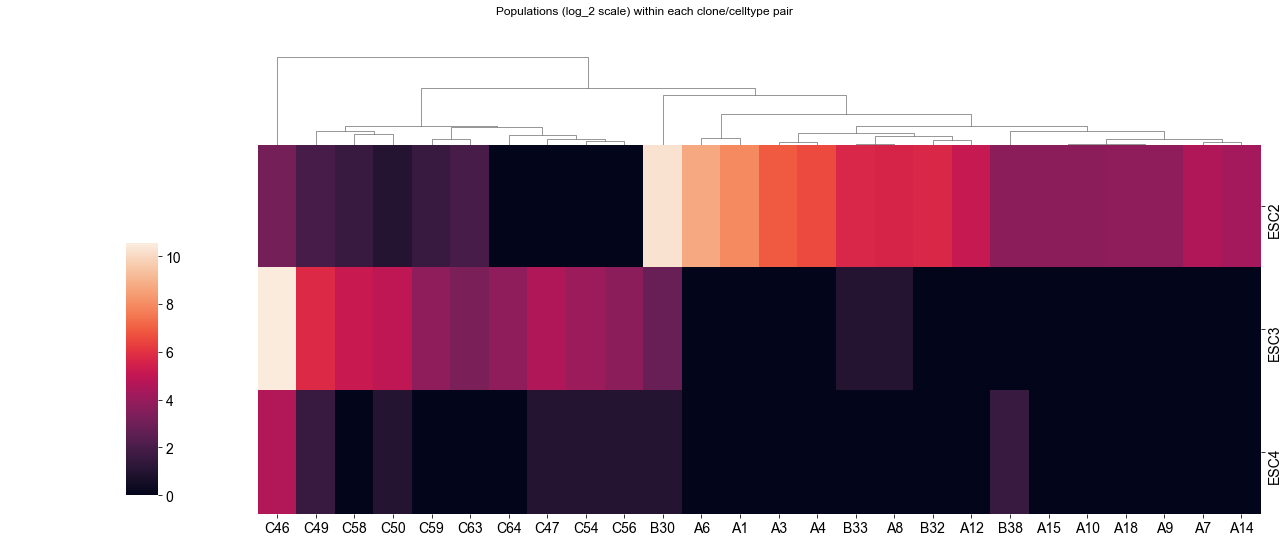

In [11]:
pop_df = pd.DataFrame(0, index = big_clones, columns = cell_types)
for cl in big_clones:
    for ct in cell_types:
        pop_df.loc[cl,ct] = len(meta_df[ (meta_df.cloneID == cl) & (meta_df.cell_type == ct)])
sns.clustermap(np.log(pop_df+1).T / np.log(2), row_cluster=False, 
               figsize=(18,7), cbar_pos = (0.1, 0.1, 0.025, 0.5))
plt.suptitle('Populations (log_2 scale) within each clone/celltype pair', y=1.07)
plt.show()

Each clone has a preference for one celltype (ESC2 or ESC3 or ESC4) over the others.

# Loading expression matrix and quality control

Now we load the gene expression matrix.  There are two such matrices -- one with raw counts, and one more processed version.  We load a more processed matrix here, which might take a few seconds.

In [12]:
data_df = pd.read_csv(directory+'data_clones.txt', sep=';')
data_df = data_df.T # I prefer the columns to be genes.
data_df.head()

,Xkr4,Gm1992,Gm37381,Rp1,Rp1.1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,Stn1,Gm45352,Gm33756,Gm13298,Ccl27,Ccl27.1,AC149090.1,CAAA01118383.1,28N-gRNA,Tomato
X10x98_AAACCCAAGACTGGGT.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.365365,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10x98_AAACGAATCTTAGGAC.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864896,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10x98_AAACGCTAGCAGAAAG.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.406784,1.047208,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10x98_AAACGCTCACCGTCGA.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.514515,0.332274,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10x98_AAACGCTCACTACGGC.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.215515,0.212853,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
print('Expression matrix loaded for {} cells and {} genes.'.format(data_df.shape[0], data_df.shape[1]))

Expression matrix loaded for 4408 cells and 32455 genes.


We look at the number of genes expressed, and the average nonzero expression, by cell type.  This is a step for quality control, and just to look for general differences between cell types.  We divide things by replicate too, as a second quality check.

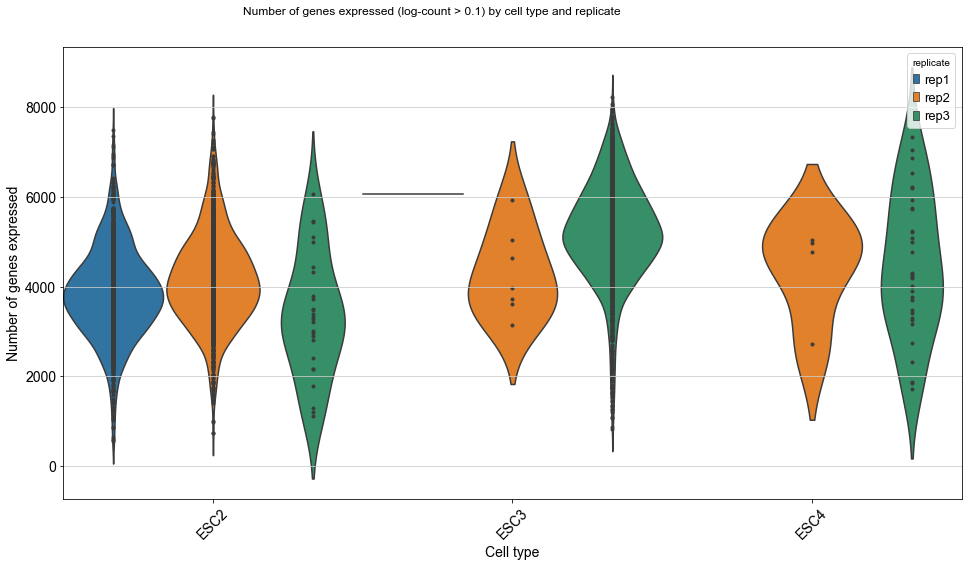

In [14]:
no_genes = (data_df > 0.1).sum(axis=1)
fig,ax = plt.subplots(figsize = (16,8))
sns.violinplot(x = meta_df.cell_type, y = no_genes, hue=meta_df.replicate, ax=ax, width=1.0, inner='point')
plt.suptitle('Number of genes expressed (log-count > 0.1) by cell type and replicate')
ax.set_ylabel('Number of genes expressed')
ax.set_xlabel('Cell type')
plt.xticks(rotation=45)
plt.show()

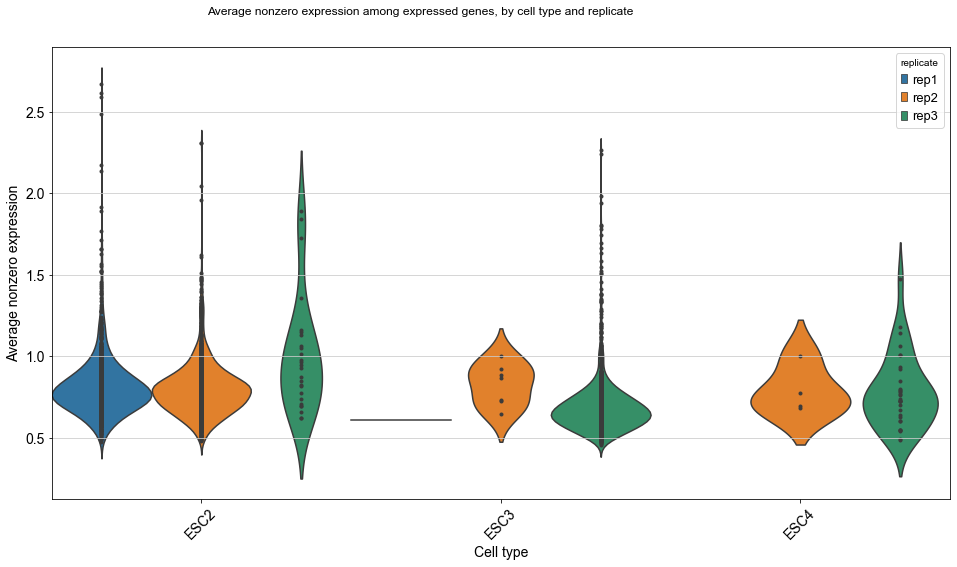

In [15]:
ave_nz_genes = data_df[data_df > 0.1].mean(axis=1)
fig,ax = plt.subplots(figsize = (16,8))
sns.violinplot(x = meta_df.cell_type, y = ave_nz_genes, inner='point', hue=meta_df.replicate, 
               width=1.0, ax=ax)
plt.suptitle('Average nonzero expression among expressed genes, by cell type and replicate')
ax.set_ylabel('Average nonzero expression')
ax.set_xlabel('Cell type')
plt.xticks(rotation=45)
plt.show()

## Moving into Scanpy

We move the expression matrices, with information about genes and cells, into Scanpy's AnnData objects.

In [16]:
def moveto_scanpy(counts, cell_meta, plain_name = True):
    adata = sc.AnnData(counts)
    for cell_property in cell_meta.columns:
        adata.obs[cell_property] = cell_meta[cell_property]
    adata.var_names_make_unique() # Use common gene names, but uniquify them.
    
    return adata

In [17]:
adata = moveto_scanpy(data_df, meta_df)

In [18]:
adata.to_df()

,Xkr4,Gm1992,Gm37381,Rp1,Rp1.1,Sox17,Gm37323,Mrpl15,Lypla1,Gm37988,...,Stn1,Gm45352,Gm33756,Gm13298,Ccl27,Ccl27.1,AC149090.1,CAAA01118383.1,28N-gRNA,Tomato
X10x98_AAACCCAAGACTGGGT.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.365365,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10x98_AAACGAATCTTAGGAC.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.864896,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10x98_AAACGCTAGCAGAAAG.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.406784,1.047208,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10x98_AAACGCTCACCGTCGA.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.514516,0.332274,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X10x98_AAACGCTCACTACGGC.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.215515,0.212853,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X100x100_TTTCGATTCCGAACGC.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.882175,0.448818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X100x100_TTTGACTAGTACCATC.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.157925,0.181057,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X100x100_TTTGATCCACGGCTAC.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.288829,0.581411,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X100x100_TTTGGAGGTTCTGACA.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,sample,percent.mito,S.Score,G2M.Score,Phase,CC.Difference,RNA_snn_res.0.1,seurat_clusters,cell_type,cloneID,region,replicate
X10x98_AAACCCAAGACTGGGT.1,10x98,17140,2873,1,0.027888,-0.148654,-0.307982,G1,0.159329,1,1,ESC2,A1,petridish,rep1
X10x98_AAACGAATCTTAGGAC.1,10x98,14548,2962,1,0.020965,-0.049652,0.014161,G2M,-0.063813,1,1,ESC2,A2,petridish,rep1
X10x98_AAACGCTAGCAGAAAG.1,10x98,16219,3455,1,0.026512,-0.234939,-0.024153,G1,-0.210786,1,1,ESC2,A1,petridish,rep1
X10x98_AAACGCTCACCGTCGA.1,10x98,25372,4218,1,0.022860,-0.108462,0.262262,G2M,-0.370723,1,1,ESC2,A1,petridish,rep1
X10x98_AAACGCTCACTACGGC.1,10x98,42158,5978,1,0.029650,-0.017082,-0.071269,G1,0.054187,1,1,ESC2,A3,petridish,rep1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X100x100_TTTCGATTCCGAACGC.1,10x100,35307,5446,3,0.036650,-0.091363,0.156901,G2M,-0.248264,2,2,ESC3,C46,petridish,rep3
X100x100_TTTGACTAGTACCATC.1,10x100,50382,6333,3,0.025307,0.024954,0.205510,G2M,-0.180556,2,2,ESC3,C46,petridish,rep3
X100x100_TTTGATCCACGGCTAC.1,10x100,38044,5673,3,0.036142,-0.146715,0.281179,G2M,-0.427895,2,2,ESC3,C46,petridish,rep3
X100x100_TTTGGAGGTTCTGACA.1,10x100,19096,4194,3,0.013982,-0.265697,-0.169354,G1,-0.096343,2,2,ESC3,C49,petridish,rep3


## Apply basic filtering

We filter out genes which do not rise above 0.1 in any cells.  We also filter out genes which are not expressed in at least 5% of cells.

In [20]:
sc.pp.filter_genes(adata, min_counts=0.1) # At least 0.1 count.
sc.pp.filter_genes(adata, min_cells=0.05*adata.n_obs) # At least 5% of cells.

In [21]:
adata

AnnData object with n_obs × n_vars = 4408 × 10848
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'RNA_snn_res.0.1', 'seurat_clusters', 'cell_type', 'cloneID', 'region', 'replicate'
    var: 'n_counts', 'n_cells'

In [22]:
adata.shape # Number of cells and number of genes remaining.

(4408, 10848)

## Scanpy quality control steps

Let's check the 10 highest expressed genes.  This can be useful for quality control.

<AxesSubplot:xlabel='% of total counts'>

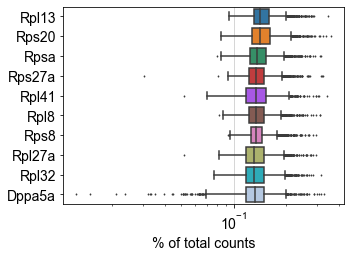

In [23]:
sc.pl.highest_expr_genes(adata, n_top=10, log=True, show=False)

We look at metrics, including number of genes expressed, total counts, and percentage of counts from mitochondrial genes.

In [24]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

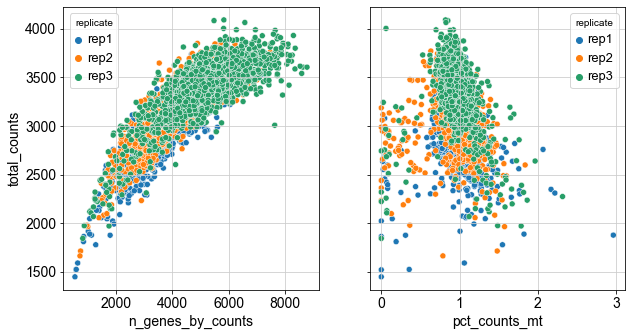

In [25]:
fig,ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
sns.scatterplot(x='n_genes_by_counts', y='total_counts', hue='replicate', data=adata.obs, ax=ax[0])
sns.scatterplot(x='pct_counts_mt', y='total_counts', hue='replicate', data=adata.obs, ax=ax[1])
plt.show()

We filter out cells with total_counts below 2500.  We also remove cells with pct_counts_mt less than 0.5 or greater than 1.5.  The result is below.

In [26]:
mt_mask = ((adata.obs.pct_counts_mt >= 0.5) & (adata.obs.pct_counts_mt <= 1.5))
mt_good_cells = mt_mask[mt_mask].index

Trying to set attribute `.obs` of view, copying.


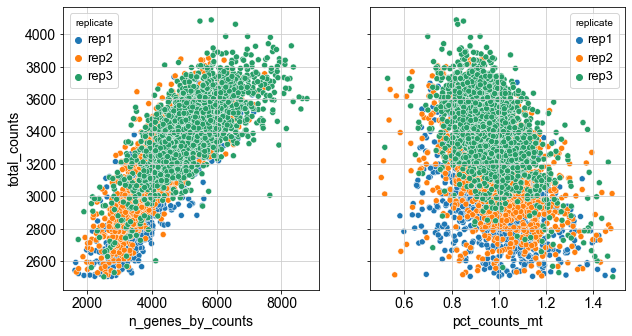

In [27]:
adata = adata[mt_good_cells,:]
sc.pp.filter_cells(adata, min_counts = 2500)

fig,ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
sns.scatterplot(x='n_genes_by_counts', y='total_counts', data=adata.obs, hue='replicate', ax=ax[0])
sns.scatterplot(x='pct_counts_mt', y='total_counts', data=adata.obs, hue='replicate', ax=ax[1])
plt.show()

# Saving data

In [28]:
adata.write_loom(file_prefix+'_mousebrains'+file_suffix)

In [29]:
adata

AnnData object with n_obs × n_vars = 4155 × 10848
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'RNA_snn_res.0.1', 'seurat_clusters', 'cell_type', 'cloneID', 'region', 'replicate', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'n_counts', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [30]:
adata.shape # Number of cells and number of genes remaining.

(4155, 10848)